# Satellite Lake Water Levels

This dataset provides water level measurements for 251 lakes across four continents, derived from satellite radar altimetry. These measurements serve as a cost-effective alternative to traditional ground-based systems and are classified as an Essential Climate Variable (ECV). The data is produced by CLS for the Copernicus Climate Change Service to enhance hydrological and climate monitoring on a continental scale.

**Information on Dataset:**
* Source: [Satellite Lake Water Levels](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-level?tab=overview)
* Author: T. Tewes (City of Konstanz)
* Notebook Version: 1.4 (Updated: January 17, 2025)

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Specify Directories Here ---- '''
download_folder = r".\data\satellite-lake-water-level\download"
working_folder = r".\data\satellite-lake-water-level\working"
geotiff_folder = r".\data\satellite-lake-water-level\geotiff"
csv_folder = r".\data\satellite-lake-water-level\csv"
output_folder = r".\data\satellite-lake-water-level\output"
''' ----- End of Declaration ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract the Dataset

### 2.1 Authentication

In [2]:
import cdsapi

def main():
    # API key for authentication
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Creation of the CDS API client
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Define the "request" and Download the Dataset

In [3]:
# Definition of the dataset and the request parameters
dataset = "satellite-lake-water-level"
request = {
    "variable": "all",
    "region": ["southern_europe"],
    "lake": ["bodensee"]
}

In [4]:
# Uncomment this cell and execute it to download the dataset:

def main_retrieve():
    dataset_filename = f"{dataset}_bodensee.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Download the dataset only if the dataset has not been downloaded before
    if not os.path.isfile(dataset_filepath):
        # Download the dataset with the defined request parameters
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Dataset already downloaded.")

if __name__ == "__main__":
    client = main()
    main_retrieve()

2025-01-21 14:30:31,314 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.


2025-01-21 14:30:31,315 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


2025-01-21 14:30:31,315 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**


2025-01-21 14:30:31,315 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


Dataset already downloaded.


### 2.3 Extract Zip Folder(s)

In [5]:
import zipfile

# Create the file name and file path for the dataset's ZIP file
dataset_filename = f"{dataset}_bodensee.zip"
dataset_filepath = os.path.join(download_folder, dataset_filename)
extract_folder = working_folder

# Extract the ZIP file
try:
    if not os.listdir(extract_folder):
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.


## 3. Read the netCDF4 file and print the Metadata

In [6]:
import netCDF4 as nc

# Open the NetCDF file in read mode
nc_filepath = os.path.join(extract_folder, os.listdir(extract_folder)[0])
dataset = nc.Dataset(nc_filepath, mode='r')

# List all variables in the dataset
variables_list = dataset.variables.keys()
print(f"Available variables: {list(variables_list)}")

Available variables: ['time', 'lat', 'lon', 'water_surface_height_above_reference_datum', 'water_surface_height_uncertainty']


In [7]:
import pandas as pd

# Define variable name from available variables and read variable data
variable_name = 'water_surface_height_above_reference_datum'
variable_data = dataset[variable_name]

# Create a summary of the primary variables
summary = {
    "Variable Name": variable_name,
    "Data Type": variable_data.dtype,
    "Shape": variable_data.shape,
    "Variable Info": f"{variable_data.dimensions}",
    "Units": getattr(variable_data, "units", "N/A"),
    "Long Name": getattr(variable_data, "long_name", "N/A"),
}

# Display the summary of the data set as a DataFrame for better visualisation
nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Details'])

# Display the summary DataFrame
nc_summary

,Description,Details
0,Variable Name,water_surface_height_above_reference_datum
1,Data Type,float64
2,Shape,"(101,)"
3,Variable Info,"('time',)"
4,Units,m
5,Long Name,water surface height above geoid


## 4. Export Dataset to CSV

### 4.1 Compute Daily Average and Export as CSV

In [8]:
import xarray as xr

# Open the NetCDF dataset using xarray
def netcdf_to_dataframe(nc_file):
    with xr.open_dataset(nc_file) as nc_dataset:
        variable_data_water_surface_height = nc_dataset['water_surface_height_above_reference_datum']
        variable_data_water_surface_height_uncertainty = nc_dataset['water_surface_height_uncertainty']

        # Convert the xarray dataset to a DataFrame
        df = variable_data_water_surface_height.to_dataframe()
        df['uncertainty'] = variable_data_water_surface_height_uncertainty.to_dataframe()

        return df

In [9]:
# Define csv filename and filepath for the output
csv_filename = 'satellite-lake-water-level.csv'
csv_filepath = os.path.join(csv_folder, csv_filename)

# Export the pivot table as CSV if it does not already exist
if not os.path.isfile(csv_filepath):
    dataframe = netcdf_to_dataframe(nc_file=nc_filepath)
    dataframe.to_csv(csv_filepath, sep=',', encoding='utf8')
    print(f"Filtered data exported successfully to {csv_filepath}")

else:
    print(f"File already exists at {csv_filepath}.\nSkipping export.")
    print("Reading existing CSV file...")
    # Read the CSV file with datetime parsing
    dataframe = pd.read_csv(csv_filepath, parse_dates=['time'], index_col='time')

# Modify pandas display options
pd.options.display.float_format = '{:,.2f}'.format
    
# Display DataFrame
dataframe.head()

File already exists at .\data\satellite-lake-water-level\csv\satellite-lake-water-level.csv.
Skipping export.
Reading existing CSV file...


,water_surface_height_above_reference_datum,uncertainty
time,,
2016-03-23 20:43:59.997482240,394.44,0.29
2016-04-19 20:43:59.997482240,394.62,0.49
2016-05-16 20:44:59.998283264,395.41,0.21
2016-06-12 20:44:59.998283264,395.72,0.58
2016-07-09 20:44:59.998283264,396.13,0.13


## 5. Analysis and Visualization

### 5.1 Visualization of all data (without a map)

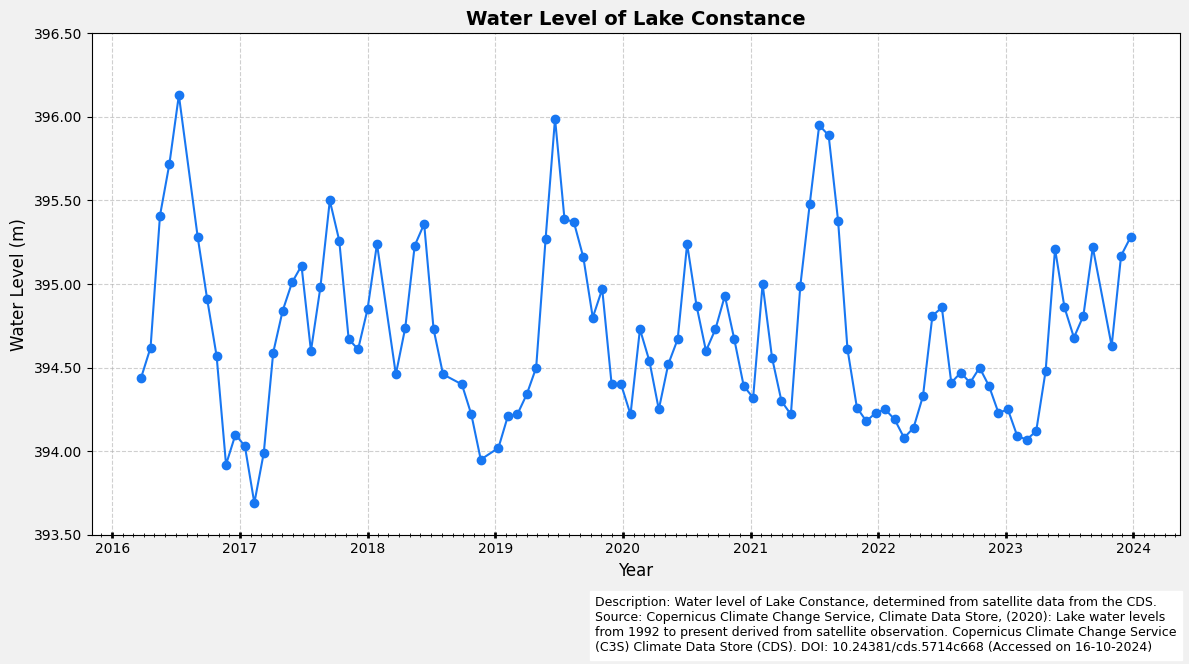

In [10]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
import matplotlib.ticker as ticker

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Plot the water level data
ax.plot(
    dataframe.index,
    dataframe['water_surface_height_above_reference_datum'],
    marker='o',
    linestyle='-',
    color='#1877F2',
    label="Water Level",
)

# Format the x-axis for better readability
ax.xaxis.set_major_locator(YearLocator())  # Major ticks for each year
ax.xaxis.set_minor_locator(MonthLocator())  # Minor ticks for each month
ax.xaxis.set_major_formatter(DateFormatter('%Y')) 
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2)
ax.tick_params(axis='x', which='minor', length=3, direction='inout')

# Set y-axis limits
ax.set_ylim(393.5, 396.5)

# Set axis labels and chart title
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Water Level (m)', fontsize=12)
ax.set_title('Water Level of Lake Constance', fontsize=14, fontweight='bold')

# Add grid to the plot and format y-axis
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add description and source information
plt.figtext(
    0.5,
    -0.05,
    (
        'Description: Water level of Lake Constance, determined from satellite data from the CDS.\n'
        'Source: Copernicus Climate Change Service, Climate Data Store, (2020): Lake water levels from 1992 '
        'to present derived from satellite observation. Copernicus Climate Change Service (C3S) Climate Data '
        'Store (CDS). DOI: 10.24381/cds.5714c668 (Accessed on 16-10-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### 5.2 Visualization of monthly averages (without a map)

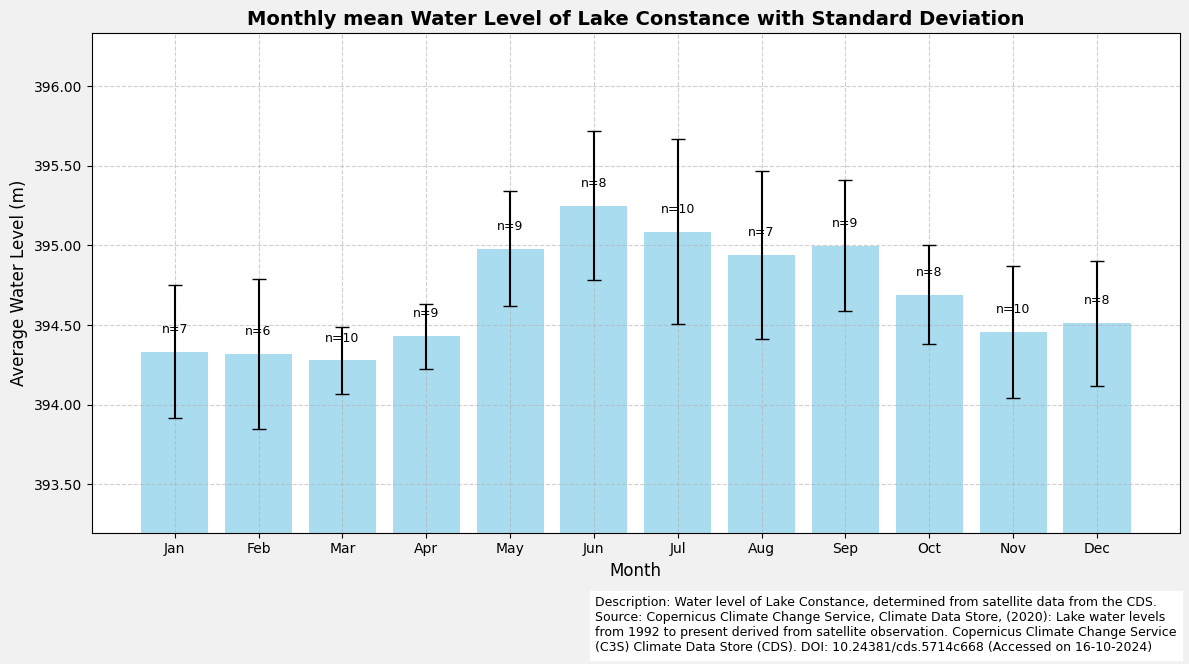

In [11]:
# Group the data by month and calculate the mean, standard deviation and sample size
monthly_data = dataframe.assign(month=dataframe.index.month).groupby('month')['water_surface_height_above_reference_datum']
# Now you can calculate mean, std, and count
monthly_mean = monthly_data.mean()
monthly_std = monthly_data.std()
monthly_n = monthly_data.count()

# Define the month labels and corresponding numerical range
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months = range(1, 13)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Plot bars with standard deviation as error bars
bars = ax.bar(
    months, 
    monthly_mean, 
    yerr=monthly_std, 
    capsize=5, 
    color='skyblue', 
    alpha=0.7, 
    error_kw=dict(ecolor='black', lw=1.5)
)

# Set the Y-axis range dynamically based on data
y_min = max(0, monthly_mean.min() - monthly_std.max() - 0.5)
y_max = monthly_mean.max() + monthly_std.max() + 0.5
ax.set_ylim(y_min, y_max)

# Set axis labels and chart title
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average Water Level (m)', fontsize=12)
ax.set_title('Monthly mean Water Level of Lake Constance with Standard Deviation', fontsize=14, fontweight='bold')

# Set X-axis labels (1 = January, 12 = December)
ax.set_xticks(months)
ax.set_xticklabels(month_labels)

# Add sample size (n) annotations above each bar
for bar, n in zip(bars, monthly_n):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.1,
        f'n={n}',
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
    
# Add a grid to the chart
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add description and source information
plt.figtext(
    0.5,
    -0.05,
    (
        'Description: Water level of Lake Constance, determined from satellite data from the CDS.\n'
        'Source: Copernicus Climate Change Service, Climate Data Store, (2020): Lake water levels from 1992 '
        'to present derived from satellite observation. Copernicus Climate Change Service (C3S) Climate Data '
        'Store (CDS). DOI: 10.24381/cds.5714c668 (Accessed on 16-10-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### 5.3 Visualization of all data (with a map)

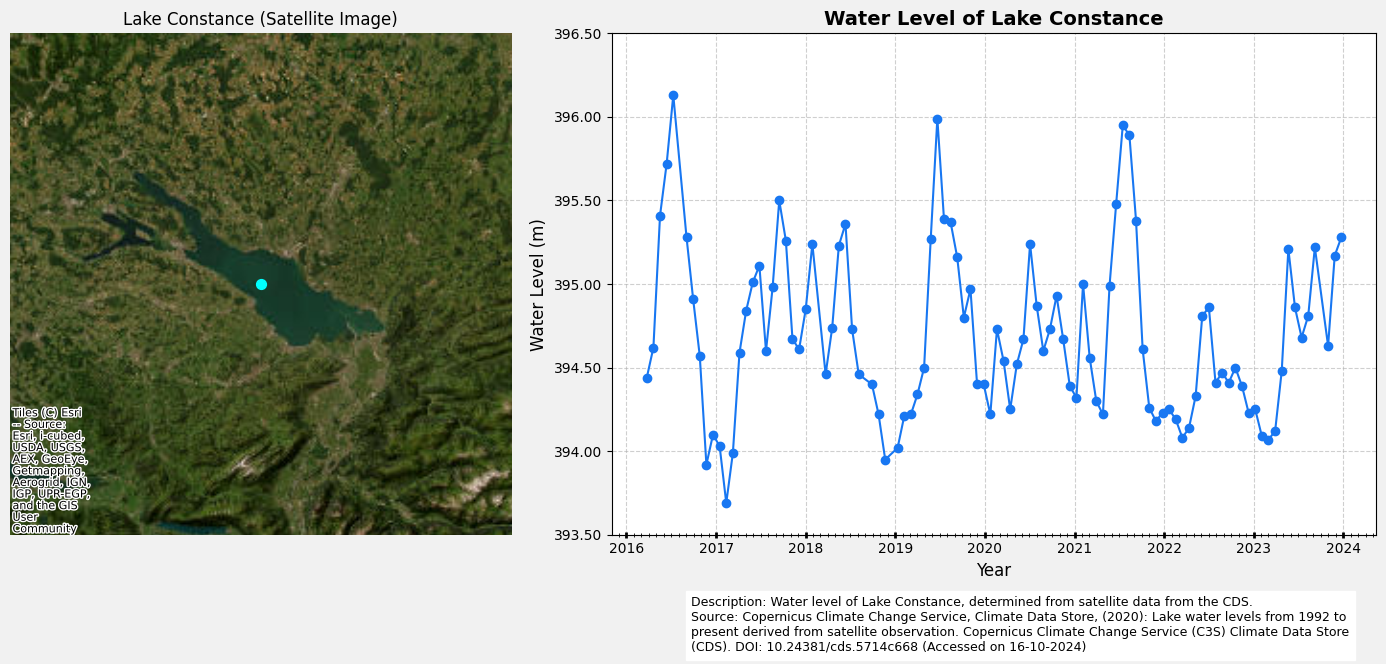

In [12]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx 

# Define the point for Lake Constance (approx. coordinates)
bodensee_point = Point(dataset['lon'][:][0], dataset['lat'][:][0])

# Create a GeoDataFrame with the Lake Constance point
lake_bodensee = gpd.GeoDataFrame(
    {'geometry': [bodensee_point]},
    crs='EPSG:4326'  # WGS84-Coordinate System
)

# Project into the Web Mercator coordinate system
lake_bodensee = lake_bodensee.to_crs(epsg=3857)

# Create the figure and axes
fig, axs = plt.subplots(1,2, figsize=(14, 6), facecolor='#f1f1f1', edgecolor='k', gridspec_kw={'width_ratios': [1, 1.5]})

# --- 1. Map of Lake Constance ---
ax = axs[0]
lake_bodensee.plot(ax=ax, color='cyan', markersize=50)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

# Adjust the visible area (zoom out further)
# Increase the area for more surroundings (here to 100 km in each direction)
ax.set_xlim(lake_bodensee.geometry.x.min() - 80000, lake_bodensee.geometry.x.max() + 80000) # Increase the area in the x direction
ax.set_ylim(lake_bodensee.geometry.y.min() - 80000, lake_bodensee.geometry.y.max() + 80000) # Increase the area in the y direction

ax.set_title("Lake Constance (Satellite Image)")
ax.set_axis_off() # Remove axis labels

# --- 2. Diagram of water level ---
ax = axs[1]

# Plot the water level data
ax.plot(
    dataframe.index,
    dataframe['water_surface_height_above_reference_datum'],
    marker='o',
    linestyle='-',
    color='#1877F2',
    label="Water Level",
)

# Format the x-axis for better readability
ax.xaxis.set_major_locator(YearLocator())  # Major ticks for each year
ax.xaxis.set_minor_locator(MonthLocator())  # Minor ticks for each month
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2)
ax.tick_params(axis='x', which='minor', length=3, direction='inout')

# Set y-axis limits
ax.set_ylim(393.5, 396.5)

# Set axis labels and chart title
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Water Level (m)', fontsize=12)
ax.set_title('Water Level of Lake Constance', fontsize=14, fontweight='bold')

# Add grid to the plot and format y-axis
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add description and source information
plt.figtext(
    0.5,
    -0.05,
    (
        'Description: Water level of Lake Constance, determined from satellite data from the CDS.\n'
        'Source: Copernicus Climate Change Service, Climate Data Store, (2020): Lake water levels from 1992 '
        'to present derived from satellite observation. Copernicus Climate Change Service (C3S) Climate Data '
        'Store (CDS). DOI: 10.24381/cds.5714c668 (Accessed on 16-10-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### 5.4 Visualization of monthly average (with a map)

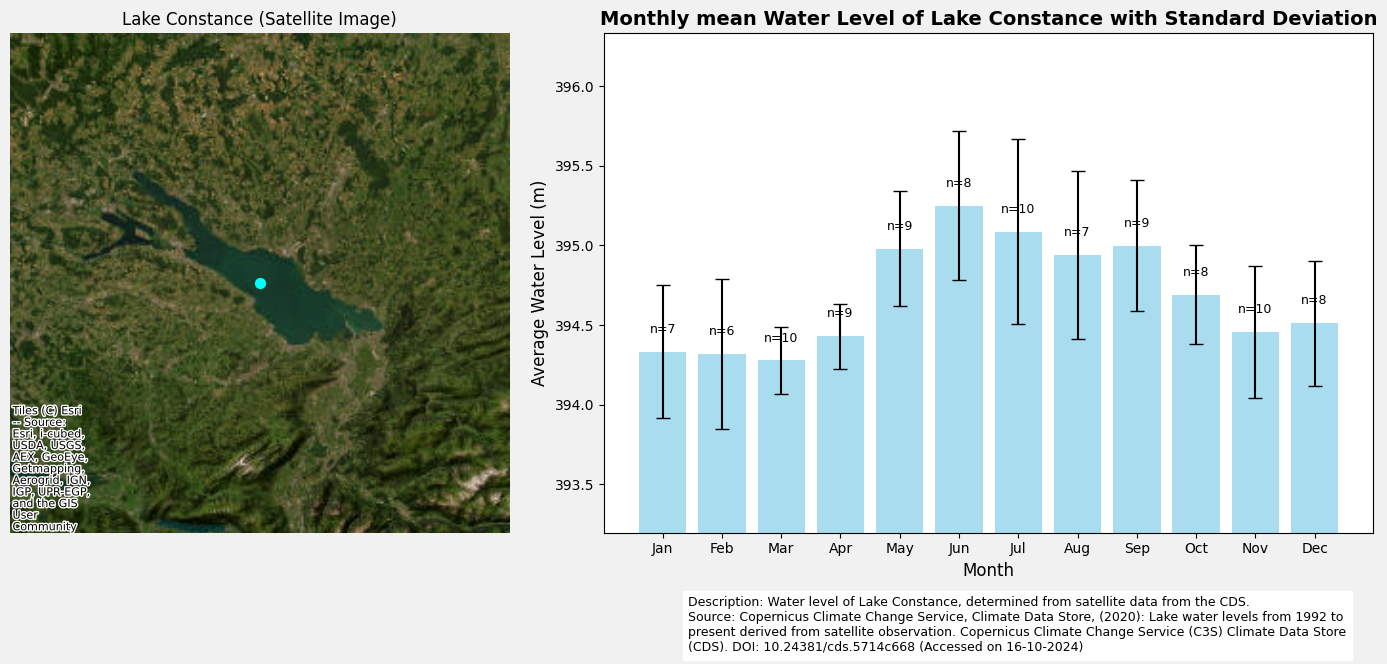

In [13]:
# Create the figure and the axes
fig, axs = plt.subplots(1,2, figsize=(14, 6), facecolor='#f1f1f1', edgecolor='k', gridspec_kw={'width_ratios': [1, 1.5]})

# --- 1. Map of Lake Constance ---
ax = axs[0]
lake_bodensee.plot(ax=ax, color='cyan', markersize=50)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

# Adjust the visible area (zoom out further)
# Increase the area for more surroundings (here to 100 km in each direction)
ax.set_xlim(lake_bodensee.geometry.x.min() - 80000, lake_bodensee.geometry.x.max() + 80000) # Increase the area in the x direction
ax.set_ylim(lake_bodensee.geometry.y.min() - 80000, lake_bodensee.geometry.y.max() + 80000) # Increase the area in the y direction

ax.set_title("Lake Constance (Satellite Image)")
ax.set_axis_off() # Remove axis labels

# --- 2. Diagram of water level ---
ax = axs[1]

# Plot bars with standard deviation as error bars
bars = ax.bar(
    months, 
    monthly_mean, 
    yerr=monthly_std, 
    capsize=5, 
    color='skyblue', 
    alpha=0.7, 
    error_kw=dict(ecolor='black', lw=1.5)
)

# Set the Y-axis range dynamically based on data
y_min = max(0, monthly_mean.min() - monthly_std.max() - 0.5)
y_max = monthly_mean.max() + monthly_std.max() + 0.5
ax.set_ylim(y_min, y_max)

# Set axis labels and chart title
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average Water Level (m)', fontsize=12)
ax.set_title('Monthly mean Water Level of Lake Constance with Standard Deviation', fontsize=14, fontweight='bold')

# Set X-axis labels (1 = January, 12 = December)
ax.set_xticks(months)
ax.set_xticklabels(month_labels)

# Add sample size (n) annotations above each bar
for bar, n in zip(bars, monthly_n):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.1,
        f'n={n}',
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
    
# Add description and source information
plt.figtext(
    0.5,
    -0.05,
    (
        'Description: Water level of Lake Constance, determined from satellite data from the CDS.\n'
        'Source: Copernicus Climate Change Service, Climate Data Store, (2020): Lake water levels from 1992 '
        'to present derived from satellite observation. Copernicus Climate Change Service (C3S) Climate Data '
        'Store (CDS). DOI: 10.24381/cds.5714c668 (Accessed on 16-10-2024)'
    ),
    ha='left',
    va='center',
    fontsize=9,
    wrap=True,
    backgroundcolor='w',
)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()